In [ ]:
# Optimization Techniques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import optimize
import random
import sys
import timeit

# Step 0
- You will get a csv file from us. Load it in your language/environment.
- Explore the data in it.

(158, 152)


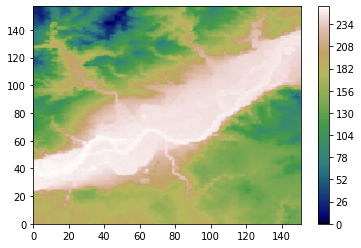

In [2]:
data = np.loadtxt("cost.csv", delimiter=",")
print(data.shape)
plt.contourf(data, levels=256, cmap='gist_earth')
plt.colorbar()
plt.show()

- Write a cost function $f(x,y) \rightarrow z$.

In [3]:
def cost(x, y):
    if x < 0 or y < 0:
        return sys.maxsize
    try:
        return data[y, x]
    except IndexError:
        return sys.maxsize

# Step 1
- Implement the Nelder-Mead simplex algorithm*. Use $\alpha=1$, $\gamma=2$, $\rho=0.5$, $\sigma=0.5$ and $t=2$.

In [1]:
def shrink(worst_points, best_point):
    sigma = 0.5
    return [tuple((1 - sigma) * best_point[i] + sigma * x for i, x in enumerate(point)) for point in worst_points]


def reflection(point, centroid, alpha: float = 1):
    return round((1 + alpha) * centroid[i] - alpha * x) for i, x in enumerate(point)


def triangle(points):
    return [(*dim_values, points[0][i]) for i, dim_values in enumerate(list(zip(*points)))]


def random_point(data: np.ndarray):
    return random.randrange(0, data.shape[1]), random.randrange(0, data.shape[0])


def random_triangle(data: np.ndarray):
    first_point = random_point(data)
    delta = 100
    other_points = ((random.randrange(max(first_point[0] - delta, 0), min(first_point[0] + delta, data.shape[1])),
                     random.randrange(max(first_point[1] - delta, 0), min(first_point[1] + delta, data.shape[0]))) for
                    _ in range(2))
    return [first_point, *other_points]

def nelder_mead(debug=True):
    # triangle_points = random_triangle(data)
    t = 2
    triangle_points = [(80, 0), (0, 150), (150, 150)]
    
    while True:
        stddev = np.std([cost(*point) for point in triangle_points])
        sorted_points = sorted(triangle_points, key=lambda point: cost(*point))
        
        x_1 = sorted_points[0]
        x_n = sorted_points[-2]
        worst_point = sorted_points[-1]
        
        if stddev < t:
            break
        
        
        centroid = tuple(sum(x) / 2 for x in zip(*sorted_points[:-1]))
        reflected_point = reflect(sorted_points[-1], centroid, alpha=1)
        expanded_point = reflect(sorted_points[-1], centroid, alpha=2)
        contracted_point = reflect(sorted_points[-1], centroid, alpha=-0.5)

        if debug:
            plt.contourf(data, levels=256, cmap='gist_earth')
            plt.colorbar()
            plt.plot(*triangle(triangle_points), 'r')
            plt.plot(*centroid, 'rx')
        
        
        if cost(*x_1) <= cost(*reflected_point) < cost(*x_n):
            triangle_points = sorted_points[:-1] + [reflected_point]
            
            if debug:
                plt.plot(*reflected_point, 'rx')
                plt.show()
                print("reflect", cost(*worst_point), "->", cost(*reflected_point))
            
        elif cost(*reflected_point) < cost(*x_1):
            if cost(*expanded_point) < cost(*reflected_point):
                triangle_points = sorted_points[:-1] + [expanded_point]
                
                if debug:
                    plt.plot(*expanded_point, 'gx')
                    plt.show()
                    print("expand", cost(*worst_point), "->", cost(*expanded_point))
            else:
                triangle_points = sorted_points[:-1] + [reflected_point]
                
                if debug:
                    plt.plot(*reflected_point, 'rx')
                    plt.show()
                    print("reflect", cost(*worst_point), "->", cost(*reflected_point))

        elif cost(*contracted_point) < cost(*worst_point):
            triangle_points = sorted_points[:-1] + [contracted_point]

            if debug:
                plt.plot(*contracted_point, 'bx')
                plt.show()
                print("contract", cost(*worst_point), "->", cost(*contracted_point))

        else:
            shrinked_points = shrink(sorted_points[1:], x_1)
            triangle_points = shrinked_points + [x_1]
            
            if debug:
                for point in shrinked_points:
                    plt.plot(*point, "gX")
                plt.show()

                print("shrink")
    return x_1

SyntaxError: invalid syntax (<ipython-input-1-e54440fa8065>, line 7)

- Find the minimum in the data.

(6, 150) ; cost: 21.0


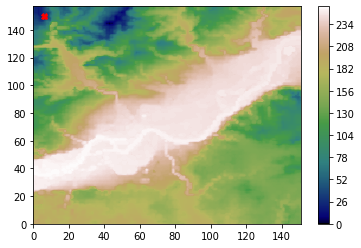

In [5]:
min_point = nelder_mead(debug=False)
print(min_point, '; cost:', cost(*min_point))
plt.contourf(data, levels=256, cmap='gist_earth')
plt.colorbar()
plt.plot(*min_point, 'rX')
plt.show()

## Step 2
- Use optim (minimize) to find the minimum with the conjugate gradient method:$f(x,y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$

In [6]:
def f(values):
    x, y = values
    return (1.5 - x + x * y) ** 2 +\
           (2.25 - x + x * y ** 2) ** 2 +\
           (2.625 - x + x * y ** 3) ** 2

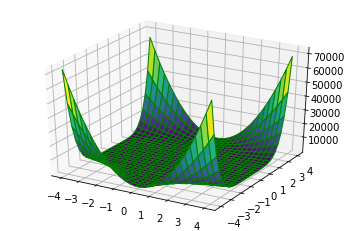

In [7]:
x = np.outer(np.linspace(-4, 4, 30), np.ones(30))
y = x.copy().T
z = f((x, y))

ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='green')
plt.show()

In [8]:
print(optimize.minimize(f, np.array([0.0, 0.0]), method='CG'))

     fun: 5.825822747402427e-11
     jac: array([-5.26310215e-06, -2.94182541e-06])
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 10
    njev: 19
  status: 0
 success: True
       x: array([2.99998094, 0.4999952 ])


- Use the pre-calculated gradient $f'(x,y)$ to boost the calculation.

In [9]:
def gradient(values):
    x, y = values
    return 2 * ((1.5 - x + x * y) * np.array([-1 + y, x]) +
                (2.25 - x + x * y ** 2) * np.array([-1 + y ** 2, 2 * x * y]) +
                (2.625 - x + x * y ** 3) * np.array([-1 + y ** 3, 3 * x * y **2]))


In [10]:
print(optimize.minimize(f, np.array([0.0, 0.0]), method='CG', jac=gradient))

     fun: 1.6405513553900587e-14
     jac: array([ 2.82251570e-07, -1.21100298e-06])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 10
    njev: 19
  status: 0
 success: True
       x: array([2.99999994, 0.49999996])


- Inspect the differences in run time.

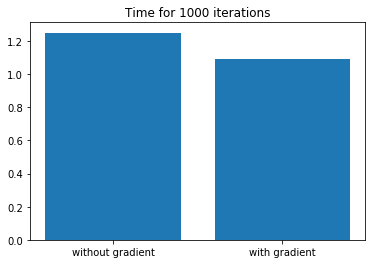

In [11]:
times_to_run=1000
times = []
times.append(timeit.timeit(
    lambda: optimize.minimize(f, np.array([0.0, 0.0]), method='CG'),
    number=times_to_run))
times.append(timeit.timeit(
    lambda: optimize.minimize(f, np.array([0.0, 0.0]), method='CG', jac=gradient),
    number=times_to_run))

names = ['without gradient', 'with gradient']

y_pos = np.arange(2)
plt.bar(y_pos, times)
plt.xticks(y_pos, names)
plt.title(f'Time for {times_to_run} iterations')
plt.show()